# Purpose of this notebook:
- Implement attribute-orthogonal multi-task training
- Train a model for engagement grading with the DAiSEE dataset

### Status:
- Multi-task training is implemented, but overfitting on the test set for gender
- attribute-orthogonal loss still needs to be implemented

# Setup
- This requires a folder structure similar to:

parent directory<br>
├─this notebook<br>
├─/dataset<br>
│  ├─/GenderClips<br>
│  │  ├─Females<br>
│  │  └─Males<br>
│  ├─/Labels<br>
│  ├─/Test<br>
│  ├─/Train<br>
│  └─/Validation<br>
├─/OUI gender dataset<br>
│  └─/OUI_model.h5

- Note: .gitignore includes the /dataset folder so that it can be co-located with the git repo for ease of use

# Sections
[Model Configuration](#section1)<br />
[Configure DAiSEE Sample Generators](#section2)<br />
[Define Attribute Orthogonal Loss](#section3)<br />
[Train Model](#section4)<br />
[Evaluation](#section5)<br />

# Imports

In [1]:
#!pip install -r requirements.txt

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from tqdm import tqdm

import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Model, Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

from keras.applications import xception
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# File handling imports
import shutil

In [2]:
# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Discovered devices: {physical_devices}')

Discovered devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#tf.config.experimental.set_memory_growth(physical_devices[0], False)
#device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "CPU")

In [4]:
#print('Device Spec: ', device_spec.to_string())

In [5]:
# Disable eager execution
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# References:
- https://github.com/zaid478/Transfer-Learning-from-Xception-Model-in-Keras-/blob/master/transfer_learn.py

<a class="anchor" id="section1"></a>
# Important Config

In [7]:
train_path = 'dataset/Train/'
test_path = 'dataset/Test/'
image_shape = (224, 299, 3) # HEIGHT, WIDTH, CHANNELS

# Import Model trained on OUI dataset

In [8]:
model_dir = "OUI gender dataset/"
model_name = 'OUI_model.h5'
OUI_model = load_model(os.path.join(model_dir, model_name))

In [9]:
OUI_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [10]:
# we'll need to reference the comparison layer
cls2a_layer = None
flatten_layer = None

# Freeze training on all layers
for layer in OUI_model.layers:
    layer.trainable = False
    
    # Get references to layers for functional API layer creation
    if layer.name == 'd1':
        cls2a_layer = layer
    elif layer.name == 'flatten':
        flatten_layer = layer
        
cls2a = cls2a_layer.output

# multi-task model references
https://medium.com/swlh/multi-task-learning-with-tf-keras-5b28dd60246e <br>
https://datascience.stackexchange.com/questions/27498/multi-task-learning-in-keras

In [11]:
flatten_layer.output

<tf.Tensor 'flatten/Reshape:0' shape=(None, 2048) dtype=float32>

In [12]:
x = flatten_layer.output

cls1a = Dense(
    512,
    activation='relu',
    name='d3',
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
)(x)

x = Dropout(rate=0.25, name="dropout_3")(cls1a)

x = Dense(
    512,
    activation='relu',
    name='d4',
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
)(x)

x = Dropout(rate=0.25, name="dropout_4")(x)

cls1_output = Dense(
    4,
    activation='softmax',
    name='cls1_output',
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
)(x)

multitask_model=Model(inputs=OUI_model.input, outputs=[cls1_output, OUI_model.output])

In [13]:
multitask_model.output

[<tf.Tensor 'cls1_output/Softmax:0' shape=(None, 4) dtype=float32>,
 <tf.Tensor 'cls2_output/Softmax:0' shape=(None, 2) dtype=float32>]

In [14]:
multitask_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

 cls1_output (Dense)            (None, 4)            2052        ['dropout_4[0][0]']              
                                                                                                  
 cls2_output (Dense)            (None, 2)            1026        ['dropout_1[0][0]']              
                                                                                                  
Total params: 23,492,142
Trainable params: 1,313,796
Non-trainable params: 22,178,346
__________________________________________________________________________________________________


In [15]:
cls1a

<tf.Tensor 'd3/Relu:0' shape=(None, 512) dtype=float32>

In [16]:
cls2a

<tf.Tensor 'd1/Relu:0' shape=(None, 512) dtype=float32>

<a class="anchor" id="section2"></a>
# DAiSEE: Create labels list

In [17]:
#validation_dataset_location = './dataset/Validation'

labels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Males'), header=None)

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

# Add gender feature columns
labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

In [18]:
labels

,ClipID,Boredom,Engagement,Confusion,Frustration,male,female
0,1100011002.avi,0,2,0,0,True,False
1,1100011003.avi,0,2,0,0,True,False
2,1100011004.avi,0,3,0,0,True,False
3,1100011005.avi,0,3,0,0,True,False
4,1100011006.avi,0,3,0,0,True,False
...,...,...,...,...,...,...,...
8920,9877360164.avi,1,3,0,0,False,True
8921,9877360165.avi,0,3,0,0,False,True
8922,9877360166.avi,1,3,0,2,False,True
8923,9877360168.avi,1,3,1,1,False,True


In [19]:
testLabels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'TestLabels.csv'))

In [20]:
labels['ClipID'].values.tolist()

['1100011002.avi',
 '1100011003.avi',
 '1100011004.avi',
 '1100011005.avi',
 '1100011006.avi',
 '1100011007.avi',
 '1100011008.avi',
 '1100011009.avi',
 '1100011010.avi',
 '1100011011.avi',
 '1100011012.avi',
 '1100011013.avi',
 '1100011014.avi',
 '1100011015.avi',
 '1100011016.avi',
 '1100011017.avi',
 '1100011018.avi',
 '1100011019.avi',
 '1100011020.avi',
 '1100011021.avi',
 '1100011022.avi',
 '1100011023.avi',
 '1100011025.avi',
 '1100011026.avi',
 '1100011027.avi',
 '1100011028.avi',
 '1100011029.avi',
 '1100011031.avi',
 '1100011032.avi',
 '1100011034.avi',
 '1100011035.avi',
 '1100011037.avi',
 '1100011038.avi',
 '1100011040.avi',
 '1100011046.avi',
 '1100011047.avi',
 '1100011048.avi',
 '1100011049.avi',
 '1100011050.avi',
 '1100011051.avi',
 '1100011052.avi',
 '1100011053.avi',
 '1100011054.avi',
 '1100011055.avi',
 '1100011056.avi',
 '1100011057.avi',
 '1100011058.avi',
 '1100011059.avi',
 '1100011060.avi',
 '1100011062.avi',
 '1100011063.avi',
 '1100011064.avi',
 '1100011066

In [21]:
missing = len(set(testLabels['ClipID'].values.tolist()) - set(labels['ClipID'].values.tolist()))
print(f'There are {missing} samples without labels!')

There are 61 samples without labels!


In [22]:
labels['ID_num'] = labels['ClipID'].str[:-4]

In [23]:
# we want to make sure that there is a binary constraint
assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

In [24]:
# Create a single column for gender
labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

In [25]:
labels.columns

Index(['ClipID', 'Boredom', 'Engagement', 'Confusion', 'Frustration ', 'male',
       'female', 'ID_num', 'gender'],
      dtype='object')

In [26]:
labels.drop(['male', 'female'], axis=1, inplace=True)

In [27]:
# We're only concerned with engagement
labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

In [28]:
labels['Engagement']

0       2
1       2
2       3
3       3
4       3
       ..
8920    3
8921    3
8922    3
8923    3
8924    1
Name: Engagement, Length: 8925, dtype: int64

In [29]:
labels_ohe = pd.get_dummies(labels.Engagement)

In [30]:
labels_ohe.head()

,0,1,2,3
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [31]:
labels_ohe['tensor'] = labels_ohe.apply(lambda x: np.array([x[0], x[1], x[2], x[3]]), axis=1)

In [32]:
labels_ohe

,0,1,2,3,tensor
0,0,0,1,0,"[0, 0, 1, 0]"
1,0,0,1,0,"[0, 0, 1, 0]"
2,0,0,0,1,"[0, 0, 0, 1]"
3,0,0,0,1,"[0, 0, 0, 1]"
4,0,0,0,1,"[0, 0, 0, 1]"
...,...,...,...,...,...
8920,0,0,0,1,"[0, 0, 0, 1]"
8921,0,0,0,1,"[0, 0, 0, 1]"
8922,0,0,0,1,"[0, 0, 0, 1]"
8923,0,0,0,1,"[0, 0, 0, 1]"


In [33]:
labels = labels.join(labels_ohe['tensor'])

In [34]:
labels.drop(['Engagement'], axis=1, inplace=True)
labels.drop(['ClipID'], axis=1, inplace=True)

In [35]:
labels.head()

,ID_num,gender,tensor
0,1100011002,1,"[0, 0, 1, 0]"
1,1100011003,1,"[0, 0, 1, 0]"
2,1100011004,1,"[0, 0, 0, 1]"
3,1100011005,1,"[0, 0, 0, 1]"
4,1100011006,1,"[0, 0, 0, 1]"


In [36]:
print("building training set")
missing_count = 0
train_set = []
for filename in tqdm(os.listdir(train_path)):
    try:
        sample_ID = filename[:filename.index('-')]
        #engagement = labels[labels['ID_num']==sample_ID].values.tolist()[0][1:-1]
        #gender = labels[labels['ID_num']==sample_ID].values.tolist()[1]
        row = labels[labels['ID_num']==sample_ID]
        engagement = row['tensor'].values[0]
        gender = row['gender'].values[0]
        train_set.append([filename, engagement, gender])
    except IndexError:
        missing_count += 1
print(f'There are {missing_count} samples without labels!')

building training set


100%|███████████████████████████████████████████████████████████████████████| 38374/38374 [00:27<00:00, 1406.98it/s]

There are 0 samples without labels!


In [37]:
print("building test set")
missing_count = 0
test_set = []
for filename in tqdm(os.listdir(test_path)):
    try:
        sample_ID = filename[:filename.index('-')]
        #engagement = labels[labels['ID_num']==sample_ID].values.tolist()[0][1:-1]
        #gender = labels[labels['ID_num']==sample_ID].values.tolist()[1]
        row = labels[labels['ID_num']==sample_ID]
        engagement = row['tensor'].values[0]
        gender = row['gender'].values[0]
        test_set.append([filename, engagement, gender])
    except IndexError:
        missing_count += 1
print(f'There are {missing_count} samples without labels!')

building test set


100%|███████████████████████████████████████████████████████████████████████| 13062/13062 [00:09<00:00, 1401.51it/s]

There are 1001 samples without labels!


In [38]:
train_df = pd.DataFrame(train_set, columns=['filename', 'engagement', 'gender'])

In [39]:
test_df = pd.DataFrame(test_set, columns=['filename', 'engagement', 'gender'])

In [40]:
train_df.describe()

,gender
count,38374.000000
mean,0.682050
std,0.465686
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [41]:
train_df.head()

,filename,engagement,gender
0,1100011002-1.jpg,"[0, 0, 1, 0]",1
1,1100011002-2.jpg,"[0, 0, 1, 0]",1
2,1100011002-3.jpg,"[0, 0, 1, 0]",1
3,1100011002-4.jpg,"[0, 0, 1, 0]",1
4,1100011002-5.jpg,"[0, 0, 1, 0]",1


In [42]:
test_df.describe()

,gender
count,12061.000000
mean,0.755078
std,0.430059
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


# ImageDataGenerator
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_dataframe/
- https://stackoverflow.com/questions/60621008/imagedatagenerator-for-multi-task-output-in-keras-using-flow-from-directory

In [43]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)
    

In [44]:
training_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col="filename",
    y_col=["engagement", "gender"],
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='multi_output',
    target_size=(image_shape[0], image_shape[1])
)

Found 38374 validated image filenames.


In [45]:
validation_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col="filename",
    y_col=["engagement", "gender"],
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='multi_output',
    target_size=(image_shape[0], image_shape[1])
)

Found 12061 validated image filenames.


In [46]:
image_shape

(224, 299, 3)

In [47]:
validation_generator[0][0].shape

(32, 224, 299, 3)

<a class="anchor" id="section3"></a>
# Implement Attribute Orthogonal Regularized Loss

In [6]:
# Reference the tensors created by layers
cls1 = cls1a
cls2 = cls2a

def orthogonal_loss(y_true, y_pred, alpha=1):
    # requires cls1, cls2 layers to be defined through functional API
    cls1_cls2 = tf.linalg.matmul(cls1, cls2, transpose_b=True)
    numerator = tf.norm(cls1_cls2, ord=1)
    cls1_norm = tf.norm(cls1, ord=2)
    cls2_norm = tf.norm(cls2, ord=2)
    denominator = tf.math.multiply(cls1_norm, cls2_norm)
    loss_ortho = tf.math.divide_no_nan(numerator, denominator)
    
    loss_categorical = keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return loss_categorical + alpha * loss_ortho

NameError: name 'cls1a' is not defined

<a class="anchor" id="section4"></a>
# Set up for training

In [49]:
%reload_ext tensorboard
model_path = os.path.join('saved_models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_.sav')
log_dir = os.path.join("logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

monitor_accuracy = 'val_cls1_output_accuracy'
monitor_mae = 'val_cls1_output_mean_absolute_error'
monitor_loss = 'val_cls1_output_loss'

# monitor_accuracy = 'val_accuracy'
# monitor_mae = 'val_mean_absolute_error'
# monitor_loss = 'val_loss'

tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_cbk = EarlyStopping(monitor=monitor_accuracy, patience=10, verbose=0, mode='max')
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor=monitor_accuracy, mode='max')
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor=monitor_loss, factor=0.1, patience=7, verbose=1, mode='min')
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [50]:
losses = {
    'cls1_output': orthogonal_loss,
    #'cls1_output': tf.keras.losses.CategoricalCrossentropy(),
    'cls2_output': tf.keras.losses.SparseCategoricalCrossentropy()
    #'cls2_output': 'sparse_categorical_crossentropy'
}

# Turn off weights for gender classifier... we are only training engagement classifier
lossWeights = {"cls1_output": 1.0, "cls2_output": 0.00001}

In [51]:
multitask_model.compile(
    loss = losses,
    loss_weights=lossWeights,
    optimizer='adam',
    metrics = ['accuracy']
)

In [52]:
history = multitask_model.fit(
    training_generator,
    validation_data=validation_generator,
    #batch_size=64,
    epochs=50,
    #steps_per_epoch=10, # Set temporarily for frequent validation
    #validation_steps = 1,
    #callbacks=callbacks)
    callbacks=[early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk]
)

Epoch 1/50
1200/1200 [==============================] - ETA: 0s - batch: 599.5000 - size: 31.9783 - loss: 2710.5580 - cls1_output_loss: 2710.5569 - cls2_output_loss: 107.4308 - cls1_output_accuracy: 0.5209 - cls2_output_accuracy: 0.7969

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1200/1200 [==============================] - 464s 385ms/step - batch: 599.5000 - size: 31.9783 - loss: 2710.5560 - cls1_output_loss: 2710.5569 - cls2_output_loss: 107.4308 - cls1_output_accuracy: 0.5209 - cls2_output_accuracy: 0.7969 - val_loss: 1236.4082 - val_cls1_output_loss: 1236.4077 - val_cls2_output_loss: 33.0183 - val_cls1_output_accuracy: 0.5448 - val_cls2_output_accuracy: 0.8960 - lr: 0.0010
Epoch 2/50
1200/1200 [==============================] - 453s 377ms/step - batch: 599.5000 - size: 31.9783 - loss: 868.2325 - cls1_output_loss: 868.2319 - cls2_output_loss: 108.7868 - cls1_output_accuracy: 0.5471 - cls2_output_accuracy: 0.7936 - val_loss: 730.6757 - val_cls1_output_loss: 730.6757 - val_cls2_output_loss: 33.0059 - val_cls1_output_accuracy: 0.5392 - val_cls2_output_accuracy: 0.8960 - lr: 0.0010
Epoch 3/50
1200/1200 [==============================] - 452s 377ms/step - batch: 599.5000 - size: 31.9783 - loss: 444.8654 - cls1_output_loss: 444.8646 - cls2_output_loss: 108.5982 - 

In [6]:
filename = 'DAiSEE-AOR-model_1.h5'
#multitask_model.save(filename)

<a class="anchor" id="section4"></a>
# Evaluation

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import load_model

from tqdm import tqdm

import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Model, Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

from keras.applications import xception
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# File handling imports
import shutil

from matplotlib import image

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], False)
# device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "CPU")

In [2]:
filename = 'DAiSEE-AOR-model_1.h5'

def orthogonal_loss(y_true, y_pred, alpha=1):
    loss_categorical = keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss_categorical

model = load_model(filename, custom_objects={'orthogonal_loss':orthogonal_loss})

In [10]:
# Importing gc module
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

Garbage collector: collected 1353 objects.


In [6]:
def prepare_sample(sample, face_only=False):

    preprocessed = tf.keras.applications.xception.preprocess_input(sample)
    
    resized = tf.image.resize(images=preprocessed,
                                size=[img_width, img_height],
                                method=tf.image.ResizeMethod.BILINEAR)
    
    reshaped = tf.reshape(resized, [1, img_width, img_height, 3]) #Reshaped it to (1,299,299,3)
    
    return reshaped
   

In [10]:
img_width = 224
img_height = 299

In [12]:
validation_dataset_location = './dataset/Validation'

labels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Males'), header=None)

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

# Add gender feature columns
labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

# we want to make sure that there is a binary constraint
assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

# Create a single column for gender
labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

labels.drop(['male', 'female'], axis=1, inplace=True)

# We're only concerned with engagement
labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

labels['ID'] = labels['ClipID'].str[:-4]
labels['ID'] = pd.to_numeric(labels['ID'])

dataset = os.path.join(os.getcwd(), 'dataset', 'Validation')

# Results should be a list in the form of:
# (y_pred, y_actual, gender)
results = []

preprocess_input = keras.applications.xception.preprocess_input

#just look at train set for now
for filename in tqdm(os.listdir(dataset)):

    img_path = os.path.join(dataset, filename)

    # Prepare image
    img = image.imread(img_path)
    #img_array = preprocess_input(get_img_array(img_path, size=img_size))
    
    img_array = prepare_sample(img)

    # Predict
    preds = model.predict(img_array, steps=1, verbose=0)
    sample_ID = filename[:filename.index('-')]
    
    y_actual = labels[labels['ID']==int(sample_ID)]['Engagement'].values[0]
    gender = labels[labels['ID']==int(sample_ID)]['gender'].values[0]

    results.append((np.argmax(preds[0], axis=1)[0], y_actual, gender))

100%|█████████████████████████████████████████████████████████████████████████| 12039/12039 [28:40<00:00,  7.00it/s]


In [220]:
preds

[array([[0., 0., 0., 1.]], dtype=float32), array([[1., 0.]], dtype=float32)]

In [13]:
results

[(2, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (2, 3, 1),
 (3, 3, 1),
 (3, 3, 1),
 (3, 3, 1),
 (2, 3, 1),
 (3, 3, 1),
 (3, 3, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (2, 3, 1),
 (1, 3, 1),
 (3, 3, 1),
 (2, 3, 1),
 (3, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (1, 2, 1),
 (2, 2, 1),
 (1, 2, 1),
 (1, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (1, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (3, 2, 1),
 (1, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (1, 2, 1),
 (2, 2, 1),
 (2, 2, 1),
 (1, 2, 1),
 (2, 3, 1),
 (2, 3, 1),
 (3, 3, 1),
 (2, 3, 1),
 (3, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (2, 3, 1),
 (3,

In [89]:
# validation_dataset_location = './dataset/Validation'
# # Alternative: generator from dataframe

# labels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'AllLabels.csv'))
# females = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Females'), header=None)
# males = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Males'), header=None)

# females_list = [x[0] for x in females.values.tolist()]
# males_list = [x[0] for x in males.values.tolist()]

# # Add gender feature columns
# labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
# labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

# testLabels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'TestLabels.csv'))

# missing = len(set(testLabels['ClipID'].values.tolist()) - set(labels['ClipID'].values.tolist()))
# print(f'There are {missing} samples without labels!')

# labels['ID_num'] = labels['ClipID'].str[:-4]

# # we want to make sure that there is a binary constraint
# assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

# # Create a single column for gender
# labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

# labels.drop(['male', 'female'], axis=1, inplace=True)

# # We're only concerned with engagement
# labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

# labels_ohe = pd.get_dummies(labels.Engagement)

# labels_ohe['tensor'] = labels_ohe.apply(lambda x: np.array([x[0], x[1], x[2], x[3]]), axis=1)

# labels = labels.join(labels_ohe['tensor'])

# labels.drop(['Engagement'], axis=1, inplace=True)
# labels.drop(['ClipID'], axis=1, inplace=True)

# #####

# # print("building validation set generator")
# # missing_count = 0
# # val_set = []
# # for filename in tqdm(os.listdir(validation_dataset_location)):
# #     try:
# #         sample_ID = filename[:filename.index('-')]
# #         #engagement = labels[labels['ID_num']==sample_ID].values.tolist()[0][1:-1]
# #         #gender = labels[labels['ID_num']==sample_ID].values.tolist()[1]
# #         row = labels[labels['ID_num']==sample_ID]
# #         engagement = row['tensor'].values[0]
# #         gender = row['gender'].values[0]
# #         val_set.append([filename, engagement, gender])
# #     except IndexError:
# #         missing_count += 1
# # print(f'There are {missing_count} samples without labels!')

# # val_df = pd.DataFrame(val_set, columns=['filename', 'engagement', 'gender'])

# # image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
# #     preprocessing_function=tf.keras.applications.xception.preprocess_input
# # )

# # validation_generator = image_generator.flow_from_dataframe(
# #     dataframe=val_df,
# #     directory=validation_dataset_location,
# #     x_col="filename",
# #     y_col="gender",
# #     batch_size=32,
# #     shuffle=True,
# #     seed=42,
# #     class_mode='raw'
# # )


# print("building test set")
# missing_count = 0
# test_set = []
# for filename in tqdm(os.listdir(test_path)):
#     try:
#         sample_ID = filename[:filename.index('-')]
#         #engagement = labels[labels['ID_num']==sample_ID].values.tolist()[0][1:-1]
#         #gender = labels[labels['ID_num']==sample_ID].values.tolist()[1]
#         row = labels[labels['ID_num']==sample_ID]
#         engagement = row['tensor'].values[0]
#         gender = row['gender'].values[0]
#         test_set.append([filename, engagement, gender])
#     except IndexError:
#         missing_count += 1
# print(f'There are {missing_count} samples without labels!')

# test_df = pd.DataFrame(test_set, columns=['filename', 'engagement', 'gender'])

There are 61 samples without labels!
building test set


100%|███████████████████████████████████████████████████████████████████████| 13062/13062 [00:10<00:00, 1216.47it/s]


There are 1001 samples without labels!


In [109]:
# validation_generator = image_generator.flow_from_dataframe(
#     dataframe=test_df,
#     directory=test_path,
#     x_col="filename",
#     y_col="gender",
#     batch_size=32,
#     shuffle=False,
#     seed=42,
#     class_mode='raw',
#     target_size=(image_shape[0], image_shape[1])
# )

Found 12061 validated image filenames.


In [116]:
# preds = model.predict(validation_generator)

In [118]:
# preds[0].shape

(12061, 4)

In [121]:
# pred_engagement = np.argmax(preds[0], axis=1)

In [124]:
# pred_engagement

array([3, 2, 2, ..., 2, 2, 2], dtype=int64)

In [125]:
# pred_gender = np.argmax(preds[1], axis=1)

In [126]:
# pred_gender

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [127]:
# df_pred_engagement = pd.DataFrame(pred_engagement, columns=['y_pred'])

In [128]:
# df_pred_engagement.head()

,y_pred
0,3
1,2
2,2
3,3
4,3


In [144]:
# result_df = test_df.join(df_pred_engagement)

In [145]:
# result_df.head()

,filename,engagement,gender,y_pred
0,5000441001-1.jpg,"[0, 0, 1, 0]",1,3
1,5000441001-2.jpg,"[0, 0, 1, 0]",1,2
2,5000441001-3.jpg,"[0, 0, 1, 0]",1,2
3,5000441001-4.jpg,"[0, 0, 1, 0]",1,3
4,5000441001-5.jpg,"[0, 0, 1, 0]",1,3


In [146]:
# result_df['y_true'] = df_result['engagement'].apply(lambda x: np.argmax(x, axis=0))

In [147]:
# result_df.head()

,filename,engagement,gender,y_pred,y_true
0,5000441001-1.jpg,"[0, 0, 1, 0]",1,3,2
1,5000441001-2.jpg,"[0, 0, 1, 0]",1,2,2
2,5000441001-3.jpg,"[0, 0, 1, 0]",1,2,2
3,5000441001-4.jpg,"[0, 0, 1, 0]",1,3,2
4,5000441001-5.jpg,"[0, 0, 1, 0]",1,3,2


In [14]:
result_df = pd.DataFrame(results, columns=['y_pred', 'y_true', 'gender'])

In [15]:
result_df.head()

,y_pred,y_true,gender
0,2,2,1
1,2,2,1
2,3,2,1
3,3,2,1
4,2,2,1


In [16]:
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

import os

from tqdm import tqdm
from matplotlib import image

import pickle

from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count
)
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, precision_score, recall_score

In [18]:
mf_res = MetricFrame(
    metrics=accuracy_score, 
    y_true=result_df['y_true'],
    y_pred=result_df['y_pred'], 
    sensitive_features=result_df['gender']
)

In [19]:
print(mf_res.by_group) # series with accuracy for each sensitive group
print(mf_res.difference()) # difference in accuracy between the two sensitive groups

gender
0    0.420091
1     0.51431
Name: accuracy_score, dtype: object
0.09421844010885105


In [20]:
# F1 scores per label
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average=None
)

array([0.        , 0.07230392, 0.61616634, 0.32050232])

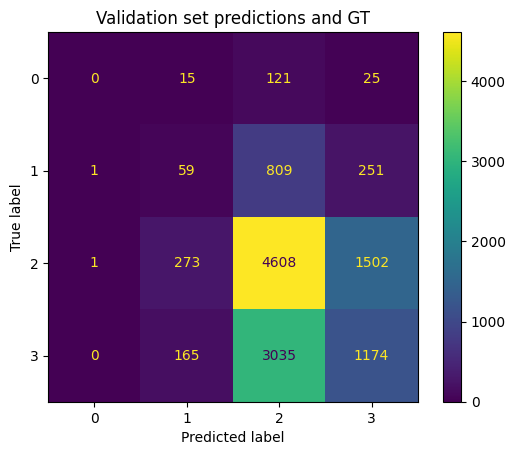

In [21]:
ConfusionMatrixDisplay.from_predictions(result_df['y_true'], result_df['y_pred'])
plt.title('Validation set predictions and GT')
plt.show()

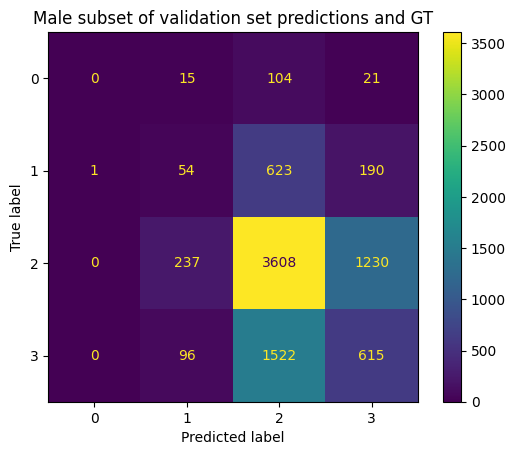

In [22]:
male_results = result_df[result_df['gender']==1]
ConfusionMatrixDisplay.from_predictions(male_results['y_true'], male_results['y_pred'])
plt.title('Male subset of validation set predictions and GT')
plt.show()

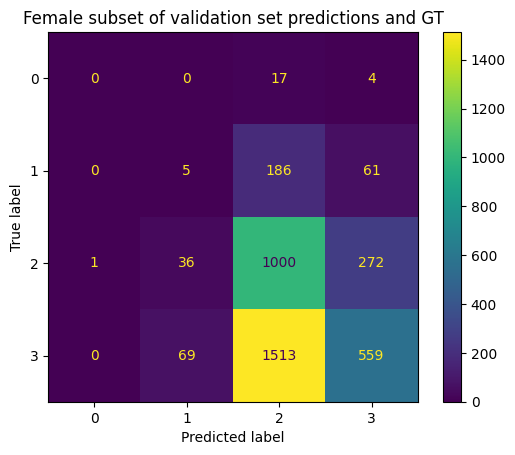

In [23]:
female_results = result_df[result_df['gender']==0]
ConfusionMatrixDisplay.from_predictions(female_results['y_true'], female_results['y_pred'])
plt.title('Female subset of validation set predictions and GT')
plt.show()

In [31]:
f1_score(
    female_results['y_true'],
    female_results['y_pred'],
    average=None
)

array([0.        , 0.02762431, 0.49689441, 0.36812644])

In [32]:
f1_score(
    male_results['y_true'],
    male_results['y_pred'],
    average=None
)

array([0.        , 0.08503937, 0.6600805 , 0.28678014])

### Check distribution of predicted labels per sensitivity group

<AxesSubplot: >

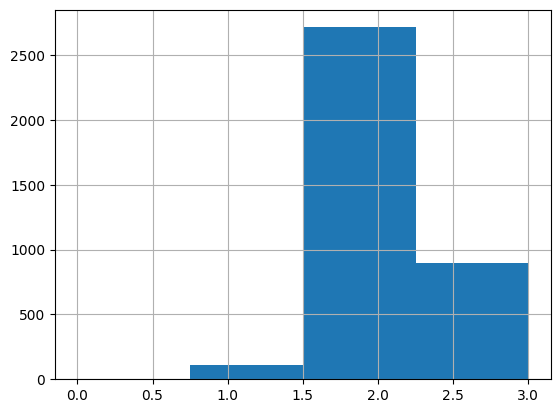

In [26]:
female_results['y_pred'].hist(bins=4)

<AxesSubplot: >

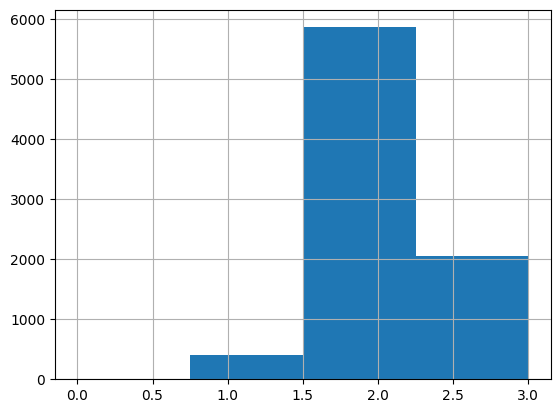

In [27]:
male_results['y_pred'].hist(bins=4)

In [179]:
male_results['y_pred'].value_counts().keys()

Int64Index([2, 3, 1], dtype='int64')

<function matplotlib.pyplot.show(close=None, block=None)>

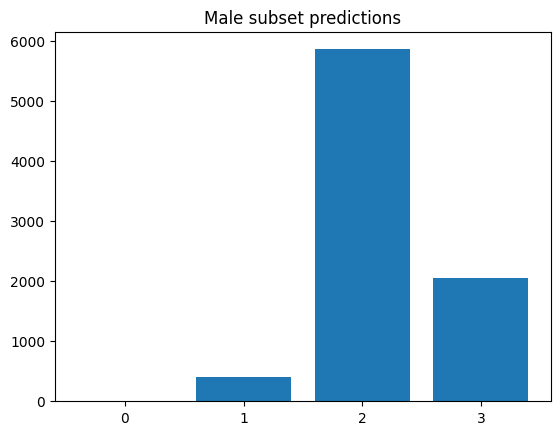

In [28]:
male_count_list = [0, 0, 0, 0]
for pred in male_results['y_pred'].value_counts().keys():
    male_count_list[pred] = male_results['y_pred'].value_counts()[pred]
    
plt.title('Male subset predictions')
plt.bar([0,1,2,3], male_count_list, width=0.8, tick_label=[0,1,2,3])
plt.show

In [184]:
female_count_list = [0, 0, 0, 0]
for pred in female_results['y_pred'].value_counts().keys():
    female_count_list[pred] = female_results['y_pred'].value_counts()[pred]

<function matplotlib.pyplot.show(close=None, block=None)>

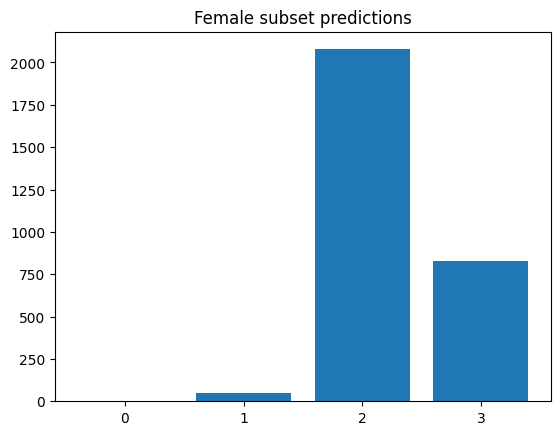

In [185]:
plt.title('Female subset predictions')
plt.bar([0,1,2,3], female_count_list, width=0.8, tick_label=[0,1,2,3])
plt.show

In [186]:
male_count_list

[0, 236, 6379, 2492]

In [187]:
female_count_list

[0, 48, 2078, 828]

In [188]:
sum(male_count_list)

9107

In [189]:
sum(female_count_list)

2954

<function matplotlib.pyplot.show(close=None, block=None)>

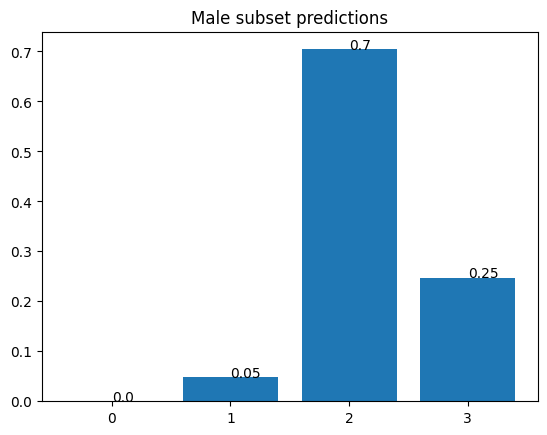

In [30]:
male_count_list = [0, 0, 0, 0]
for pred in male_results['y_pred'].value_counts().keys():
    male_count_list[pred] = male_results['y_pred'].value_counts()[pred] / sum(male_results['y_pred'].value_counts())
    
plt.title('Male subset predictions')
plt.bar([0,1,2,3], male_count_list, width=0.8, tick_label=[0,1,2,3])
for idx, value in enumerate(male_count_list):
    plt.text(idx, value, round(value, 2))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

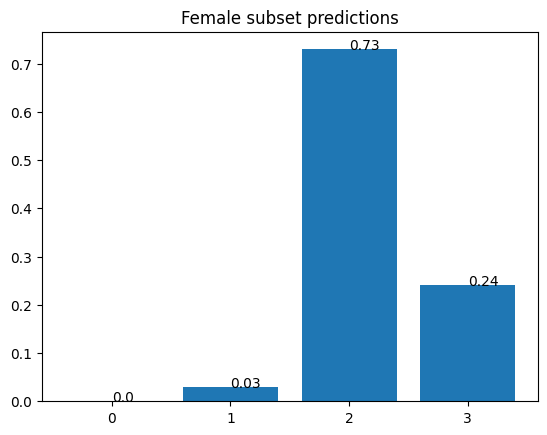

In [29]:
female_count_list = [0, 0, 0, 0]
for pred in female_results['y_pred'].value_counts().keys():
    female_count_list[pred] = female_results['y_pred'].value_counts()[pred] / sum(female_results['y_pred'].value_counts())
    
plt.title('Female subset predictions')
plt.bar([0,1,2,3], female_count_list, width=0.8, tick_label=[0,1,2,3])
for idx, value in enumerate(female_count_list):
    plt.text(idx, value, round(value, 2))
plt.show

# END